In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
from typing import Optional

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import core.config as cconfig
import core.plotting as coplotti
import dataflow.core as dtfcore
import dataflow.model as dtfmod
import helpers.hdatetime as hdateti
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import helpers.hs3 as hs3
import oms.broker.ccxt.ccxt_broker_instances as obccbrin
import oms.hsecrets as homssec
import reconciliation as reconcil

/app/amp/core/explore.py:39: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tauton


In [3]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-21feec48-f16a-4ed0-a973-05ef9ad3cca9.json'
INFO  # Git
  branch_name='CmTask7933_Add_alerts_to_the_scheduled_monitoring_flow_1'
  hash='3af8fdaf3'
  # Last commits:
    * 3af8fdaf3 Sameep2808 Update                                                            (  19 hours ago) Mon Apr 22 18:25:39 2024  (HEAD -> CmTask7933_Add_alerts_to_the_scheduled_monitoring_flow_1, origin/CmTask7933_Add_alerts_to_the_scheduled_monitoring_flow_1)
    * cfee271bf Sameep2808 Update                                                            (  20 hours ago) Mon Apr 22 17:27:02 2024           
    * 09dffbced Sameep2808 CmTask7933_Add_alerts_to_the_scheduled_monitoring_flow_1          (  21 hours ago) Mon Apr 22 16:31:25 2024           
# Machine info
  system=Linux
  node name=d7460b900dd7
  release=5.15.0-1056-aws
  version=#61~20.04.1-Ubuntu SMP Wed Mar 13 17:40:41 UTC 2024
  machine=x86_64
 

# Last update time

In [4]:
# TODO(Grisha): tz should go to notebook's config.
tz = "ET"
current_time = hdateti.get_current_time(tz)
print(current_time)

2024-04-23 09:54:56.803647-04:00


# Build the reconciliation config

In [5]:
# When running manually, specify the path to the config to load config from file,
# for e.g., `.../reconciliation_notebook/fast/result_0/config.pkl`.
config_file_name = None
config = cconfig.get_notebook_config(config_file_name)
if config is None:
    _LOG.info("Using hardwired config")
    # Specify the config directly when running the notebook manually.
    # Below is just an example.
    prod_data_root_dir = "/shared_data/CmTask7933/system_reconciliation"
    dag_builder_ctor_as_str = (
        "dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp"
    )
    run_mode = "paper_trading"
    start_timestamp_as_str = "20240415_131000"
    end_timestamp_as_str = "20240416_130500"
    mode = "scheduled"
    save_plots_for_investors = True
    html_bucket_path = henv.execute_repo_config_code("get_html_bucket_path()")
    s3_dst_dir = os.path.join(html_bucket_path, "pnl_for_investors")
    config_list = reconcil.build_system_observer_configs(
        prod_data_root_dir,
        dag_builder_ctor_as_str,
        run_mode,
        start_timestamp_as_str,
        end_timestamp_as_str,
        mode,
        save_plots_for_investors,
        s3_dst_dir=s3_dst_dir,
    )
    config = config_list[0]
print(config)

WARNING No config found, returning None
INFO  Using hardwired config
INFO  run_date='20240415'
INFO  Using run_date=20240415
INFO  dst_root_dir='/shared_data/CmTask7933/system_reconciliation', dag_builder_name='C3a', run_mode='paper_trading', start_timestamp_as_str='20240415_131000', end_timestamp_as_str='20240416_130500'
INFO  target_dir='/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500'
INFO  system_log_dir='system_log_dir.scheduled'
meta: 
  dag_builder_name: C3a
  date_str: 20240415
  bar_duration: 5T
  save_plots_for_investors: True
s3_dst_dir: s3://cryptokaizen-html/pnl_for_investors
system_log_dir: /shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled
dag_builder_ctor_as_str: dataflow_orange.pipelines.C3.C3a_pipeline_tmp.C3a_DagBuilder_tmp
research_forecast_evaluator_from_prices: 
  init: 
    price_col: vwap
    prediction_col: feature
    volatility_col: garman_kla

# System config

In [6]:
# Load the system config.
config_file_name = "system_config.output.values_as_strings.pkl"
system_config_path = os.path.join(config["system_log_dir"], config_file_name)
system_config = cconfig.load_config_from_pickle(system_config_path)
print(system_config)

dag_config: 
  compute_bar_feature: 
    in_col_groups: [('close',), ('high',), ('low',)]
    out_col_group: ()
    transformer_kwargs: 
      close_col: close
      high_col: high
      low_col: low
    drop_nans: True
  resample: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',), ('stochastic',), ('volume',)]
    out_col_group: ()
    transformer_kwargs: 
      rule: 5T
      resampling_groups: [({'close': 'close'}, 'last', {}), ({'high': 'high'}, 'max', {}), ({'low': 'low'}, 'min', {}), ({'open': 'open'}, 'first', {}), ({'volume': 'volume'}, 'sum', {'min_count': '1'}), ({'close': 'twap'}, 'mean', {})]
      vwap_groups: [('close', 'volume', 'vwap'), ('stochastic', 'volume', 'cmf')]
    reindex_like_input: False
    join_output_with_input: False
  compute_vol: 
    in_col_groups: [('close',), ('high',), ('low',), ('open',)]
    out_col_group: ()
    transformer_kwargs: 
      estimators: ['close', 'parkinson', 'garman_klass']
      open_col: open
      high_col: high
  

# Current balance, open positions

In [7]:
# Real broker is used only with production runs so we check balance and open
# positions only for this run mode. Paper trading is run with fake broker so we
# can't get such info.
if system_config["run_mode"] == "prod":
    # Get Broker.
    universe_version = system_config["market_data_config"]["universe_version"]
    # TODO(Grisha): store `exchange, preprod, account_type, secret_id` as separate
    # fields in SystemConfig.
    exchange, preprod, account_type, secret_id = system_config[
        "secret_identifier_config"
    ].split(".")
    secret_identifier = homssec.SecretIdentifier(
        exchange, preprod, account_type, secret_id
    )
    # Use temporary local dir in order not to override related production results
    # for this run.
    broker = obccbrin.get_CcxtBroker_exchange_only_instance1(
        universe_version, secret_identifier, "/app/tmp.log_dir"
    )

In [8]:
if system_config["run_mode"] == "prod":
    broker.get_open_positions()

In [9]:
if system_config["run_mode"] == "prod":
    total_balance = broker.get_total_balance()
    _LOG.info(total_balance)

# Specify data to load

In [10]:
# Points to `system_log_dir/dag/node_io/node_io.data`.
data_type = "dag_data"
dag_data_path = reconcil.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_data_path=%s", dag_data_path)
# Points to `system_log_dir/dag/node_io/node_io.prof`.
data_type = "dag_stats"
dag_info_path = reconcil.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("dag_info_path=%s", dag_info_path)
# Points to `system_log_dir/process_forecasts/portfolio`.
data_type = "portfolio"
portfolio_path = reconcil.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("portfolio_path=%s", portfolio_path)
# Points to `system_log_dir/process_forecasts/orders`.
data_type = "orders"
orders_path = reconcil.get_data_type_system_log_path(
    config["system_log_dir"], data_type
)
_LOG.info("orders_path=%s", orders_path)

INFO  dag_data_path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/dag/node_io/node_io.data
INFO  dag_info_path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/dag/node_io/node_io.prof
INFO  portfolio_path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/portfolio
INFO  orders_path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/orders


# DAG io

## Load

In [11]:
# Get DAG node names.
dag_node_names = dtfcore.get_dag_node_names(dag_data_path)
_LOG.info(
    "First node='%s' / Last node='%s'", dag_node_names[0], dag_node_names[-1]
)

INFO  First node='predict.0.read_data' / Last node='predict.5.process_forecasts'


In [12]:
# Get timestamps for the last DAG node.
dag_node_timestamps = dtfcore.get_dag_node_timestamps(
    dag_data_path, dag_node_names[-1], as_timestamp=True
)
_LOG.info(
    "First timestamp='%s'/ Last timestamp='%s'",
    dag_node_timestamps[0][0],
    dag_node_timestamps[-1][0],
)

INFO  First timestamp='2024-04-15 09:10:00-04:00'/ Last timestamp='2024-04-16 09:05:00-04:00'


In [13]:
# Get DAG output for the last node and the last timestamp.
dag_df_prod = dtfcore.load_dag_outputs(dag_data_path, dag_node_names[-1])
_LOG.info("Output of last node:")
hpandas.df_to_str(dag_df_prod, num_rows=5, log_level=logging.INFO)

INFO  Output of last node:


feature                                                                                                                                                                                                                                                    close_vol                                                                                                                                                                                                                                                   garman_klass_vol                                                                                                                                                                                                                                                   parkinson_vol                                                                                                                                                                                                                                                        close                                                                                                                                                                                                                                                          cmf                                                                                                                                                                                                                                                         high                                                                                                                                                                                                                                                          low                                                                                                                                                                                                                                                         open                                                                                                                                                                                                                                                         twap                                                                                                                                                                                                                                                       volume                                                                                                                                                                                                                                                          vwap                                                                                                                                                                                                                                                         
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5118394986 6051632686 8717633868 8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5118394986 6051632686 8717633868 8968126878 9872743573    1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 26

## Compute DAG execution time

In [14]:
df_dag_execution_time = dtfcore.get_execution_time_for_all_dag_nodes(
    dag_data_path
)
_LOG.info("DAG execution time:")
hpandas.df_to_str(df_dag_execution_time, num_rows=5, log_level=logging.INFO)

INFO  DAG execution time:


,all_nodes,read_data,compute_bar_feature,resample,compute_vol,generate_feature,process_forecasts
2024-04-15 09:10:00-04:00,11.0,1.41,2.397,2.219,1.83,1.417,1.727
2024-04-15 09:15:00-04:00,11.384,1.52,2.244,2.554,1.948,1.713,1.405
,...,...,...,...,...,...,...
2024-04-16 09:00:00-04:00,14.368,1.415,2.735,3.296,2.269,2.131,2.522
2024-04-16 09:05:00-04:00,16.265,1.364,2.809,2.984,3.529,3.258,2.321


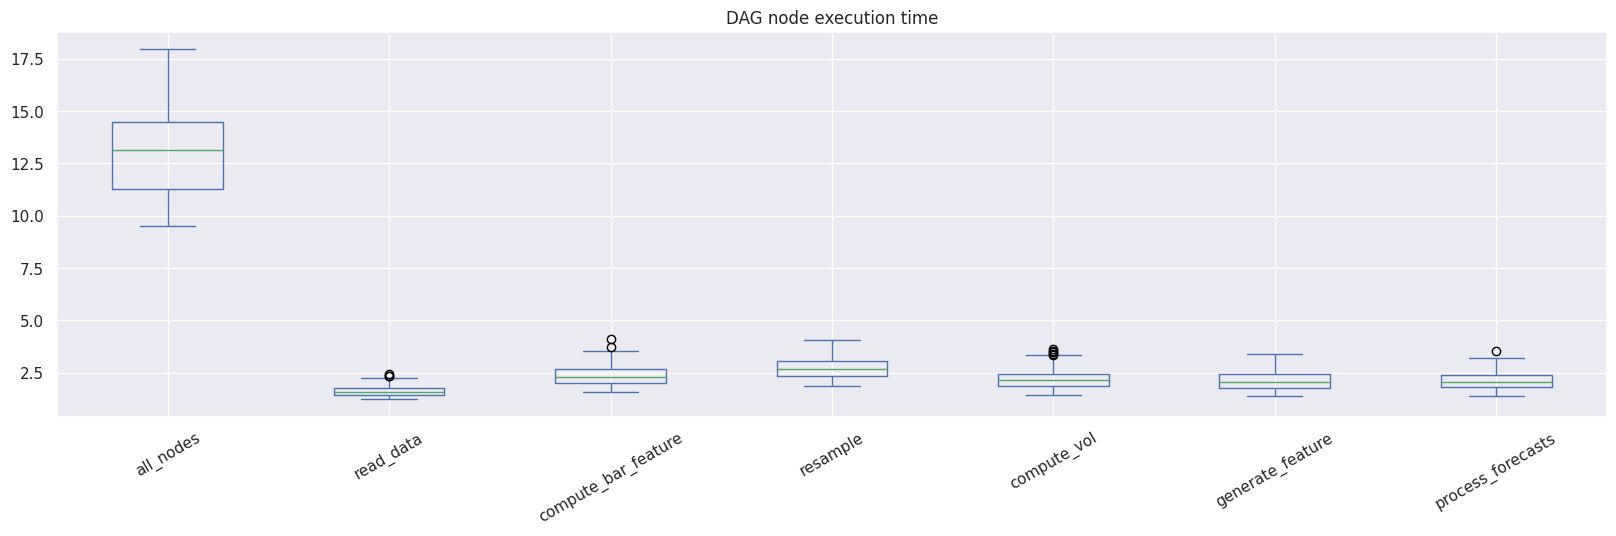

In [15]:
dtfcore.plot_dag_execution_stats(df_dag_execution_time, report_stats=False)

In [16]:
# The time is an approximation of how long it takes to process a bar. Technically the time
# is a distance (in secs) between wall clock time when an order is executed and a bar
# timestamp. The assumption is that order execution is the very last stage.
df_order_execution_time = dtfcore.get_orders_execution_time(orders_path)
# TODO(Grisha): consider adding an assertion that checks that the time does not
# exceed one minute.
_LOG.info(
    "Max order execution time=%s secs",
    df_order_execution_time["execution_time"].max(),
)

INFO  Max order execution time=51 secs


# Portfolio

## Compute research portfolio equivalent

In [17]:
# Set Portofolio start and end timestamps.
start_timestamp = dag_node_timestamps[0][0]
end_timestamp = dag_node_timestamps[-1][0]
_LOG.info("start_timestamp=%s", start_timestamp)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-04-15 09:10:00-04:00
INFO  end_timestamp=2024-04-16 09:05:00-04:00


In [18]:
fep = dtfmod.ForecastEvaluatorFromPrices(
    **config["research_forecast_evaluator_from_prices"]["init"]
)
annotate_forecasts_kwargs = config["research_forecast_evaluator_from_prices"][
    "annotate_forecasts_kwargs"
].to_dict()
research_portfolio_df, research_portfolio_stats_df = fep.annotate_forecasts(
    dag_df_prod,
    **annotate_forecasts_kwargs,
    compute_extended_stats=True,
)
# TODO(gp): Move it to annotate_forecasts?
research_portfolio_df = research_portfolio_df.sort_index(axis=1)
# Align index with prod portfolio.
research_portfolio_df = research_portfolio_df.loc[start_timestamp:end_timestamp]
research_portfolio_stats_df = research_portfolio_stats_df.loc[
    start_timestamp:end_timestamp
]
#
hpandas.df_to_str(research_portfolio_stats_df, num_rows=5, log_level=logging.INFO)

/venv/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1001) is greater than the total number of samples (23). n_quantiles is set to n_samples.
  warnings.warn(


,pnl,gross_volume,net_volume,gmv,nmv,gpc,npc,wnl
2024-04-15 09:10:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-15 09:15:00-04:00,0.0,3043.341367,209.683906,3043.341367,209.683906,22.0,0.0,0.0
,...,...,...,...,...,...,...,...
2024-04-16 09:00:00-04:00,-0.624394,4821.305601,-915.972557,2971.077993,-438.409394,21.0,-1.0,-2.0
2024-04-16 09:05:00-04:00,-0.295811,3565.416285,111.482858,3029.602643,-327.222347,22.0,0.0,-1.0


## Load logged portfolios (prod & research)

In [19]:
portfolio_dfs, portfolio_stats_dfs = reconcil.load_portfolio_dfs(
    {"prod": portfolio_path},
    config["meta"]["bar_duration"],
)
# Add research portfolio.
portfolio_dfs["research"] = research_portfolio_df
hpandas.df_to_str(portfolio_dfs["prod"], num_rows=5, log_level=logging.INFO)

INFO  Processing portfolio=prod path=/shared_data/CmTask7933/system_reconciliation/C3a/paper_trading/20240415_131000.20240416_130500/system_log_dir.scheduled/process_forecasts/portfolio


Loading `holdings_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `holdings_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_shares` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `executed_trades_notional` files...:   0%|          | 0/288 [00:00<?, ?it/s]

Loading `statistics` files...:   0%|          | 0/288 [00:00<?, ?it/s]

holdings_shares                                                                                                                                                                                                                                                              holdings_notional                                                                                                                                                                                                                                                                  executed_trades_shares                                                                                                                                                                                                                                                              executed_trades_notional                                                                                                                                                                                                                                                                         pnl                                                                                                                                                                                                                                                             
                               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986        1030828978  1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510  2384892553 2425308589 2484635488 2540896331  2601760471 2683705052 3065029174 3401245610 4516629366  5118394986 6051632686 8717633868 8968126878 9872743573 5115052901             6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901 3065029174 1891737434 3401245610 1464553467 1966583502 1030828978 2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553 5118394986               6051632686 8717633868 2540896331 1528092593 8968126878 1467591036 5115052901  3065029174 1891737434 3401245610  1464553467 1966583502 1030828978  2601760471 2683705052 9872743573 2484635488 2099673105 4516629366 2237530510 2425308589 1776791608 2384892553  5118394986 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
2024-04-15 09:10:00-04:00             0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0               0.0         0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0         0.0        0.0        0.0        0.0        0.0        NaN                    0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0        0.0                      NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN         NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN         NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN     

In [20]:
# Add research df and combine into a single df.
portfolio_stats_dfs["research"] = research_portfolio_stats_df
portfolio_stats_df = pd.concat(portfolio_stats_dfs, axis=1)
#
hpandas.df_to_str(portfolio_stats_df, num_rows=5, log_level=logging.INFO)

prod                                                                                       research                                                                  
                                pnl gross_volume   net_volume          gmv         nmv        cash  net_wealth  leverage       pnl gross_volume  net_volume          gmv         nmv   gpc  npc  wnl
2024-04-15 09:10:00-04:00       NaN          0.0          0.0          0.0         0.0       700.0       700.0       0.0       NaN          NaN         NaN          NaN         NaN   NaN  NaN  NaN
2024-04-15 09:15:00-04:00       0.0   3008.63173    -50.42419   3008.63173   -50.42419   750.42419       700.0  4.298045       0.0  3043.341367  209.683906  3043.341367  209.683906  22.0  0.0  0.0
                                ...          ...          ...          ...         ...         ...         ...       ...       ...          ...         ...          ...         ...   ...  ...  ...
2024-04-16 09:00:00-04:00 -0.275234  4689.195422 -1179.671358  2992.094684  -585.08486  1291.04808   705.96322  4.238315 -0.624394  4821.305601 -915.972557  2971.077993 -438.409394  21.0 -1.0 -2.0
2024-04-16 09:05:00-04:00  1.130468  3717.828712   356.734808  3047.653896 -227.219584  934.313272  707.093688  4.310113 -0.295811  3565.416285  111.482858  3029.602643 -327.222347  22.0  0.0 -1.0

## Compute Portfolio statistics (prod vs research)

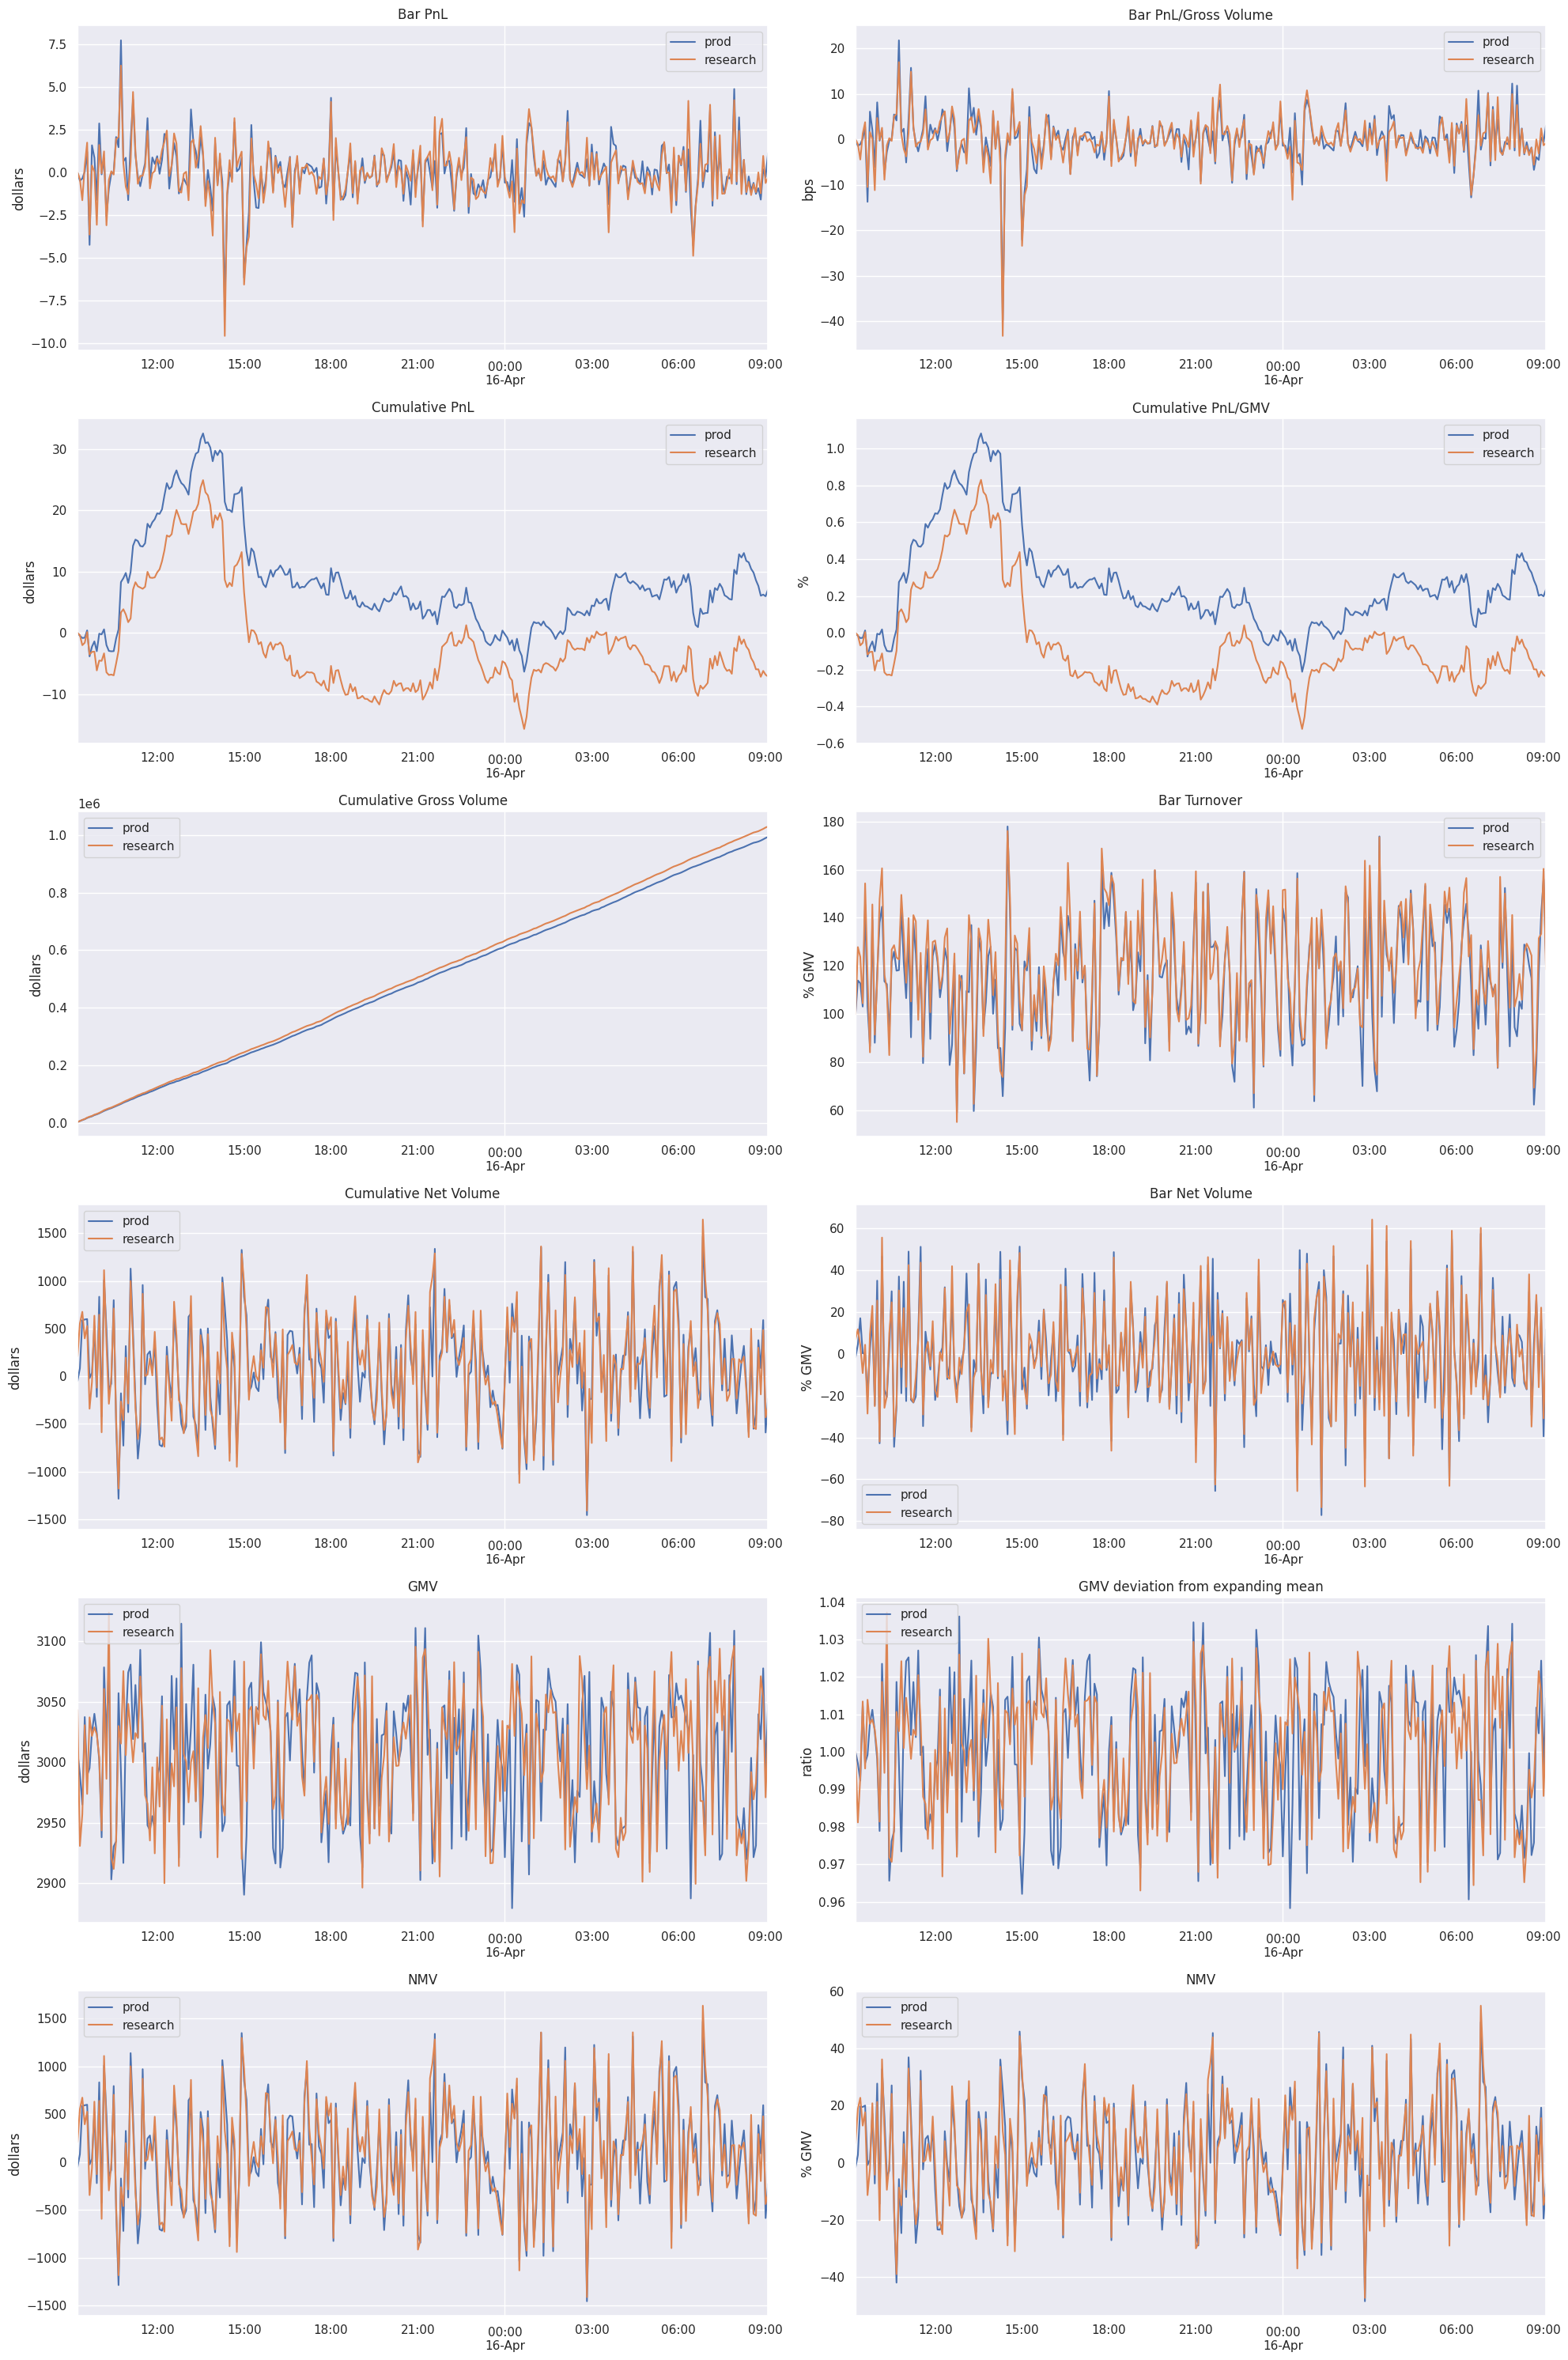

In [21]:
bars_to_burn = 1
coplotti.plot_portfolio_stats(portfolio_stats_df.iloc[bars_to_burn:])

In [22]:
stats_computer = dtfmod.StatsComputer()
stats_sxs, _ = stats_computer.compute_portfolio_stats(
    portfolio_stats_df.iloc[bars_to_burn:], config["meta"]["bar_duration"]
)
display(stats_sxs)

prod  research
ratios     sharpe_ratio                    5.10     -4.84
           sharpe_ratio_standard_error    19.18     19.18
           sr.tval                         0.27     -0.25
           sr.pval                         0.79      0.80
           kratio                         -7.49    -10.19
dollar     gmv_mean                     3004.67   3006.51
           gmv_stdev                      54.48     51.22
           annualized_mean_return       2599.11  -2611.96
           annualized_volatility         509.56    539.37
           max_drawdown                   38.86     40.58
           pnl_mean                        0.02     -0.02
           pnl_std                         1.57      1.66
           turnover_mean                3462.30   3588.46
           turnover_stdev                687.22    694.38
           market_bias_mean               92.97    103.72
           market_bias_stdev             538.58    535.42
percentage annualized_mean_return         86.50    -86.88
           annualized_volatility          16.96     17.94
           max_drawdown                    1.29      1.35
           pnl_mean                        0.00     -0.00
           pnl_std                         0.05      0.06
           turnover_mean                 115.23    119.36
           turnover_stdev                 22.87     23.10
           market_bias_mean                3.09      3.45
           market_bias_stdev              17.92     17.81

In [23]:
# Check the balance. Assert if it's below the threshold.
if system_config["run_mode"] == "prod":
    # TODO(Nina): pass via notebook's config.
    balance_threshold = -1000
    usdt_balance = total_balance["USDT"]
    _LOG.info("Current USDT balance is %s", usdt_balance)
    #
    msg = f"USDT balance is below the threshold: {usdt_balance} < {balance_threshold} USDT"
    hdbg.dassert_lt(balance_threshold, usdt_balance, msg=msg)

In [24]:
pnl = portfolio_stats_df.T.xs("pnl", level=1).T
cum_pnl = pnl.cumsum()
# Assert if PnL below the threshold.
# TODO(Nina): pass via notebook's config.
pnl_threshold = -100
# Check the latest row, i.e. for current timestamp.
pnl = cum_pnl["prod"].iloc[-1]
_LOG.info("Current PnL is %s", pnl)
#
msg = f"Cumulative PnL in $ is below the threshold: {pnl} < {pnl_threshold}$"
hdbg.dassert_lt(pnl_threshold, pnl, msg=msg)

INFO  Current PnL is 7.093688000000958


In [25]:
# Check cumulative PnL in relative terms.
# TODO(Nina): pass via notebook's config.
fraction_threshold = -0.1
#
gmv = portfolio_stats_df.T.xs("gmv", level=1).T
gmv = gmv.replace(0, np.nan)
rolling_gmv = gmv.expanding().mean()
# To compute average GMV use GMV values available up to the current point in time.
cum_pnl_gmv = cum_pnl.divide(rolling_gmv)["prod"].iloc[-1]
_LOG.info("Current cumulative PnL as fraction of GMV is %s", cum_pnl_gmv)
#
msg = f"Cumulative PnL as fraction of GMV is below the threshold {cum_pnl_gmv} < {fraction_threshold}"
hdbg.dassert_lt(fraction_threshold, cum_pnl_gmv, msg=msg)

INFO  Current cumulative PnL as fraction of GMV is 0.002360889139563174


# PnL for investors

In [26]:
# TODO(Grisha): move to a lib.
def adjust_matplotlib_settings() -> None:
    """
    Adjust the Matplotlib settings for readability.
    """
    # Matplotlib setting to make the plots readable in presentations.
    matplotlib.rcParams.update({"font.size": 22})
    #
    BIG_SIZE = 22
    #
    plt.rc("font", size=BIG_SIZE)  # controls default text sizes
    plt.rc("axes", titlesize=BIG_SIZE)  # fontsize of the axes title
    plt.rc("axes", labelsize=BIG_SIZE)  # fontsize of the x and y labels
    plt.rc("xtick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("ytick", labelsize=BIG_SIZE)  # fontsize of the tick labels
    plt.rc("legend", fontsize=BIG_SIZE)  # legend fontsize
    plt.rc("figure", titlesize=BIG_SIZE)  # fontsize of the figure title
    #
    matplotlib.rcParams["figure.dpi"] = 300


# TODO(Grisha): move to a lib.
def plot_cumulative_pnl(
    cumul_pnl: pd.Series,
    plot_title: str,
    *,
    save_to_tmp_file: bool = True,
    copy_to_s3: bool = True,
    s3_dst_file_path: Optional[str] = None,
) -> None:
    """
    Plot cumulative PnL.

    :param cumul_pnl: cumulative PnL
    :param plot_title: title for the plot
    :param save_to_tmp_file: save the plot locally to a tmp file if True,
        proceed otherwise
    :param copy_to_s3: copy to the saved plot to S3 if True, proceed otherwise
    :param s3_dst_file_path: path on S3 to copy the saved plot to, e.g.,
        `s3://.../system_reconciliation/test_image.png`
    """
    adjust_matplotlib_settings()
    # TODO(Grisha): set `target_gmv` properly instead.
    cumul_pnl = cumul_pnl * 1000
    ax = cumul_pnl.plot(title=plot_title)
    # Set the labels formatting, e.g., `1000.0` -> `$1,000`.
    ax.yaxis.set_major_formatter("${x:,.0f}")
    if save_to_tmp_file:
        # Save the plot locally to a tmp file.
        tmp_file_path = "/app/tmp.png"
        _LOG.info("Saving the PnL plot to %s", tmp_file_path)
        plt.savefig(tmp_file_path, bbox_inches="tight")
        if copy_to_s3:
            # Copy a tmp file to S3.
            aws_profile = "ck"
            hs3.copy_file_to_s3(tmp_file_path, s3_dst_file_path, aws_profile)
    # Saving must precede `show()`.
    plt.show()

INFO  Saving the PnL plot to /app/tmp.png
INFO  Copying from /app/tmp.png to s3://cryptokaizen-html/pnl_for_investors/cumulative_pnl.last_24hours.png
upload: ../../../tmp.png to s3://cryptokaizen-html/pnl_for_investors/cumulative_pnl.last_24hours.png


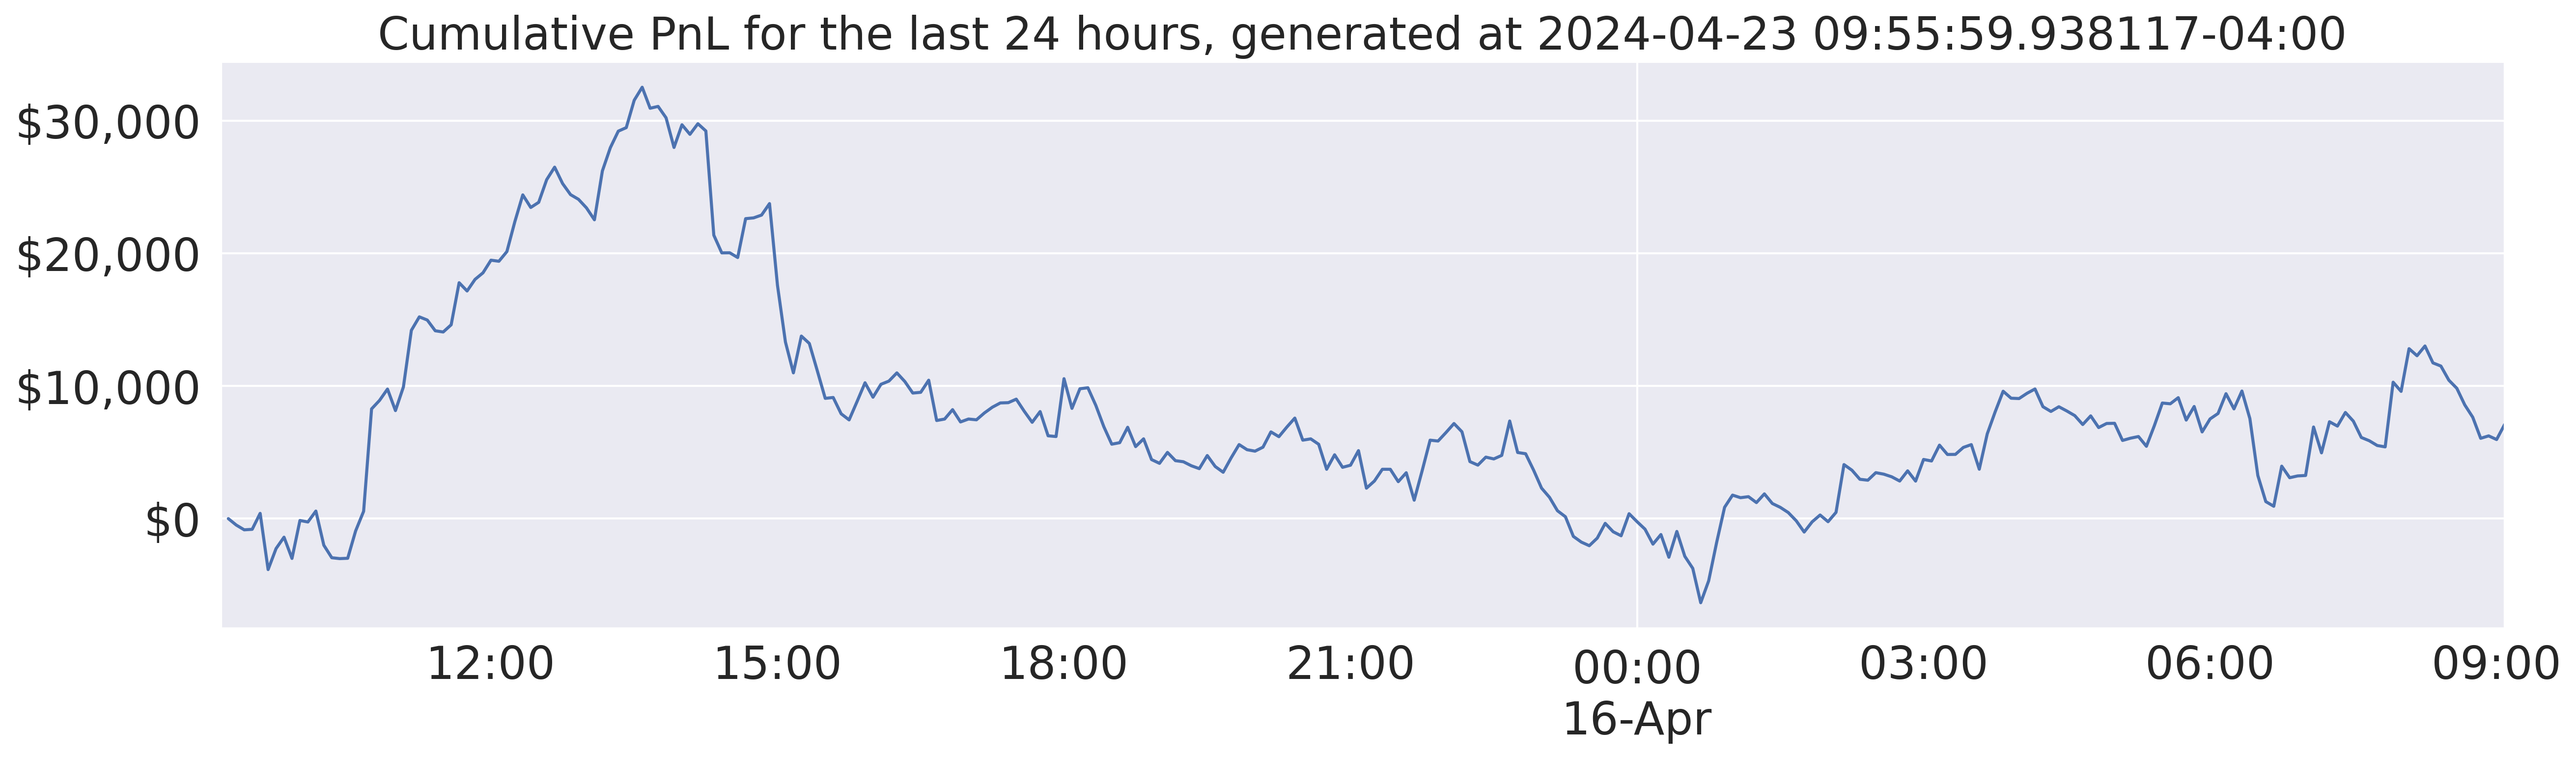

In [27]:
# Save the plots only for C3a.
if (
    config["meta"]["dag_builder_name"] == "C3a"
    and config["meta"]["save_plots_for_investors"]
):
    pnl_df = portfolio_stats_df["prod"]
    # Get the number of hours for which the system is run.
    bar_duration_in_minutes = int(config["meta"]["bar_duration"].rstrip("T"))
    pnl_num_hours = pnl_df.shape[0] * bar_duration_in_minutes / 60
    # Verify that the number of hours is in [0,24] range.
    hdbg.dassert_lgt(
        0,
        pnl_num_hours,
        24,
        lower_bound_closed=False,
        upper_bound_closed=True,
    )
    # TODO(Grisha): this is a hack. Ideally we should schedule a DAG
    # after the prod run is finished to get a plot for 24 hours.
    current_et_time = hdateti.get_current_time("ET")
    if round(pnl_num_hours) == 24:
        # A 24 hours run is a complete run so save as the last 24 hours results.
        file_name = "cumulative_pnl.last_24hours.png"
        plot_title = f"Cumulative PnL for the last 24 hours, generated at {current_et_time}"
    else:
        # If a run is not complete save as last 5 minutes results.
        file_name = "cumulative_pnl.last_5minutes.png"
        plot_title = f"Cumulative PnL for the last 5 minutes, generated at {current_et_time}"
    cumul_pnl = pnl_df["pnl"].cumsum()
    s3_dst_path = os.path.join(config["s3_dst_dir"], file_name)
    save_to_tmp_file = True
    copy_to_s3 = True
    plot_cumulative_pnl(
        cumul_pnl,
        plot_title,
        save_to_tmp_file=save_to_tmp_file,
        copy_to_s3=copy_to_s3,
        s3_dst_file_path=s3_dst_path,
    )